This notebook shows the scripts to load data and plotting the Polarimetric phase curve.


In [1]:
%config InlineBackend.figure_format = 'retina'

In [17]:
from io import StringIO
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysvisutilpy as yvu

def trigp(x, h, c1, c2, a0):
    xx = np.deg2rad(x)
    a0 = np.deg2rad(a0)
    return h * (np.sin(xx)/np.sin(a0))**c1 * (np.cos(xx / 2)/np.cos(a0 / 2))**c2 * np.sin(xx - a0)


uddata = StringIO('''alpha value value_err
68.1 23.24 3.58
63.62 20.48 1.14
55.45 12.45 1.55
33.5 4.24 0.18
29.29 2.48 0.08
25.47 1.54 0.07
11.67 -0.79 0.09
8.66 -1.25 0.07''')
# 46.41 7.97 12.16 is removed

uddata = pd.read_csv(uddata, sep=' ')
DATADIR = Path("../data")

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

In [13]:
pol = pd.read_excel(DATADIR/"pol_data.xlsx")
pol = pol.loc[(pol["filter"].isin([0.65, 0.68]))
             |(pol["filter"].str.startswith("R"))]
polg = pol.groupby('reference')
phae_2016 = pol.loc[(pol['id'] == 3200) 
                   &(pol['reference'].isin(["2018NatCo...9.2486I"]))]
phae_2017 = pol.loc[(pol['id'] == 3200) 
                   &(pol['reference'].isin(["2018ApJ...864L..33S", "2018MNRAS.479.3498D"]))]

[ 7.60810629  1.16914494 -1.3272084  19.64656231]
[12.37911968  0.62670509 -1.18775131 19.97413876]


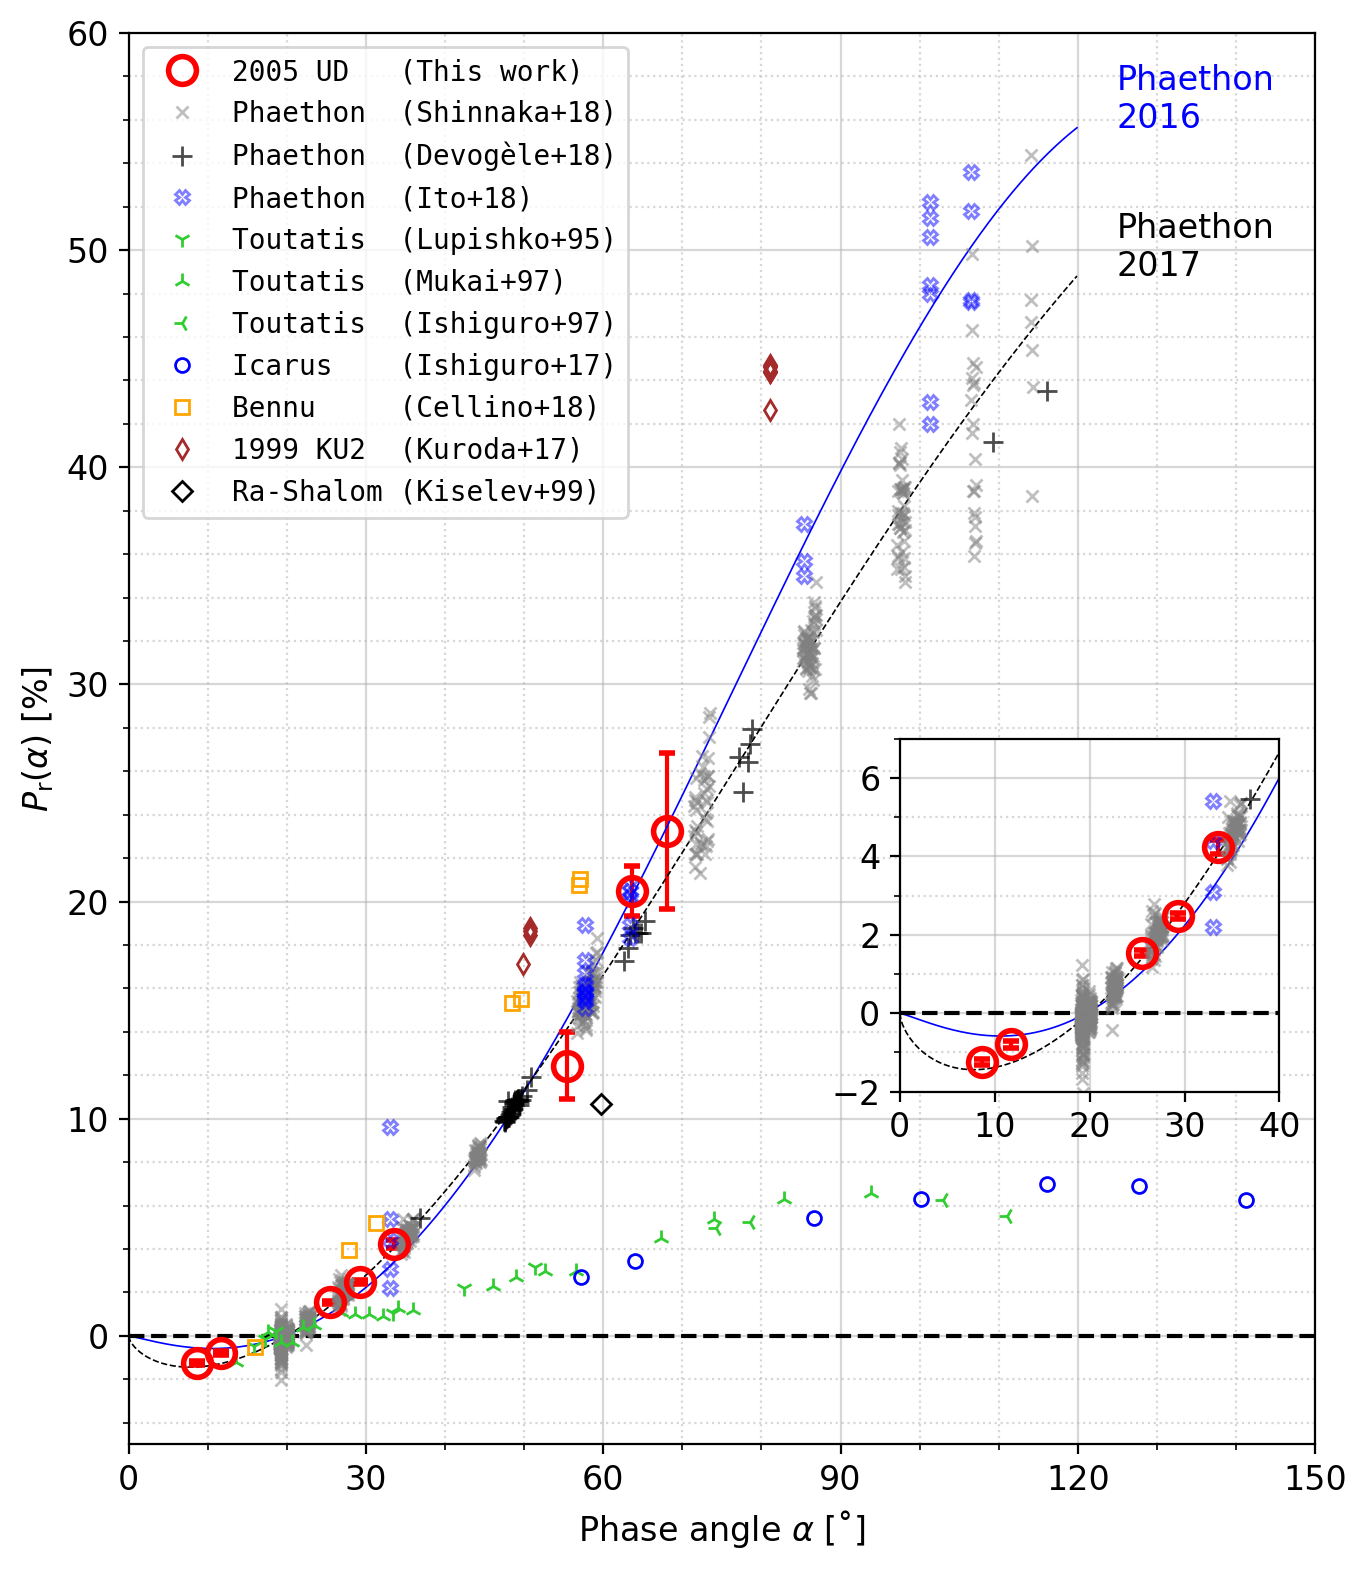

In [88]:
kws = {
    "2018ApJ...864L..33S": dict(label="Phaethon  (Shinnaka+18)", marker='x', mfc='none', ms=4, color='gray', alpha=0.5),
    "2018MNRAS.479.3498D": dict(label="Phaethon  (Devogèle+18)", marker='+', mfc='none', ms=7, color='k', alpha=0.7),
    "2018NatCo...9.2486I": dict(label="Phaethon  (Ito+18)"     , marker='X', mfc='none', ms=5, color='b', alpha=0.5),
    "1995Icar..113..200L": dict(label="Toutatis  (Lupishko+95)", marker='1', mfc='none', ms=6, color='limegreen'),
    "1997Icar..127..452M": dict(label="Toutatis  (Mukai+97)"   , marker='2', mfc='none', ms=6, color='limegreen'),
    "1997PASJ...49L..31I": dict(label="Toutatis  (Ishiguro+97)", marker='3', mfc='none', ms=6, color='limegreen'),
    "2017AJ....154..180I": dict(label="Icarus    (Ishiguro+17)", marker='o', mfc='none', ms=5, color='b'),
    "2018MNRAS.481L..49C": dict(label="Bennu     (Cellino+18)" , marker='s', mfc='none', ms=5, color='orange'),
    "2018A&A...611A..31K": dict(label="1999 KU2  (Kuroda+17)"  , marker='d', mfc='none', ms=5, color='brown'),
    "1999Icar..140..464K": dict(label="Ra-Shalom (Kiselev+99)" , marker='D', mfc='none', ms=5, color='k'),
}

udkw = dict(marker='o', color='r', mfc='none', ms=10, mew=2, ls='', capsize=3, alpha=1)
udplot = dict(x=uddata.alpha, y=uddata.value, yerr=uddata.value_err)
errbfmt = dict(ls='', capsize=1, elinewidth=0.5)
alpha_plot = np.arange(0, 120, 0.1)

fig, axs = plt.subplots(1, 1, figsize=(7, 8), 
                        sharex=False, sharey=False, gridspec_kw=None)
ax0 = axs
axi = ax0.inset_axes([0.65, 0.25, 0.32, 0.25])

ax0.errorbar(np.nan, np.nan, **udkw, label="2005 UD   (This work)")

for ref, kw in kws.items():
    g = polg.get_group(ref)
    ax0.errorbar(g.alpha, g.value, #g.value_err, 
                 **errbfmt, **kws[ref])
    if kw['label'].startswith("Phaethon"):
        axi.errorbar(g.alpha, g.value, #g.value_err, 
                     **errbfmt, **kws[ref])

for phae, ls, c, y in zip([phae_2016, phae_2017], ['-', '--'], ['b', 'k'], ['2016', '2017']):
    popt, _ = curve_fit(trigp, phae.alpha, phae.value, 
                        p0=(1, 1, 1, 20),
#                         bounds=((0, 0, 0, 5),
#                                 (100, 10, 10, 30)),
                        sigma=phae.value_err, absolute_sigma=True)
    print(popt)
    ax0.plot(alpha_plot, trigp(alpha_plot, *popt), ls=ls, color=c, lw=0.6)
    ax0.text(alpha_plot[-1] + 5, trigp(alpha_plot, *popt)[-1], f"Phaethon\n{y}", color=c)
    axi.plot(alpha_plot, trigp(alpha_plot, *popt), ls=ls, color=c, lw=0.6)
    
ax0.errorbar(**udplot, **udkw)
axi.errorbar(**udplot, **udkw)
ax0.axhline(0, linestyle='--', color='k')
axi.axhline(0, linestyle='--', color='k')

ax0.legend(prop={'family': 'monospace', 'size': 10})
# ax0.legend()
ax0.set(
    xlim=(0, 150),
    ylim=(-5, 60),
    xlabel=r"Phase angle $\alpha$ [˚]",
    ylabel=r"$P_\mathrm{r}(\alpha)$ [%]"
)

axi.set(
    xlim=(0, 40), 
    ylim=(-2, 7),
#     xlabel=r"Phase angle $\alpha$ [˚]",
#     ylabel=r"$P_\mathrm{r}(\alpha)$ [%]"
)
# ax0.indicate_inset_zoom(axi)

yvu.linticker([ax0, axi], 
              xmajlockws=[30, 10], 
              xminlockws=[10, None], 
              ymajlockws=[10, 2], 
              yminlockws=[2, 1])

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

In [141]:
g

,id,name,altname,date,middletime,jd,alpha,value,value_err,reference,obsmode,filter,weighted_mean,N,exptime,comment,airmass
1030,2100,Ra-Shalom,1978 RA,1997-08-03,00:12:58,NaN,59.7,10.7,0.2,1999Icar..140..464K,pol,0.68,1,NaN,1800.0,"value_err = rms of P, not CLT, not dPr",NaN
